# Sentiment Analysis of drug reviews using Logistic Regression
This notebook builds an LSTM model to classify drug reviews as either positive or negative.

### Notebook Contributors

-   Michael Skirvin : EDA , Feature Engeneering, Model Training and Evaluation, Conclusions.

-   Swathi Subramanyam & Iman Hamdan : Code Review 

#### import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# nltk.download('vader_lexicon')

# from tqdm.notebook import tqdm
from sklearn.utils import resample

from sklearn import preprocessing


#### Data Preparation

•	Loads Data: Reads the training (drugsComTrain_raw.tsv) and testing (drugsComTest_raw.tsv) datasets from the data folder.

•	Processes Data:

Converts the drugName and condition columns to uppercase for consistency.

Calculates the number of unique drugs and conditions and prints these counts.

•	Feature Engineering:

Adds a new column, review_len, to store the length of each review.

Adds a binary target column, is_positive:

1: If the rating > 7 (positive review).

0: Otherwise (negative review).

•	Balances Classes:

Calls the balance_class function to handle class imbalance in both the training and testing datasets by resampling.

VADER (Valence Aware Dictionary and sEntiment Reasoner) is used to calculate sentiment polarity scores for each review.

•	Calculates the following sentiment scores for each review:

Negative (neg): Proportion of negative sentiment in the review.

Positive (pos): Proportion of positive sentiment.

Compound: Overall sentiment score (-1 to 1) summarizing the polarity.

Appends these scores as new columns (neg, pos, compound) to the DataFrame.

In [24]:
def get_train_test():
    # cwd = os.getcwd()
    # print(cwd)

    df_train = pd.read_csv("./data/drugsComTrain_raw.tsv", sep='\t')
    df_test = pd.read_csv("./data/drugsComTest_raw.tsv", sep='\t')

    df_list = [df_train, df_test]

    # print(f"train_len={train_len} test_len={test_len} df_len={len(df)}")
    print(df_train.columns)

    df_train['drugName'] = df_train['drugName'].str.upper()
    number_of_drugs = len(df_train['drugName'].unique())
    print(f"Number of drugs = {number_of_drugs}")

    df_train['condition'] = df_train['condition'].str.upper()
    number_of_drugs = len(df_train['condition'].unique())
    print(f"Number of condition = {number_of_drugs}")

    # Generate columns for review length and positive reviews.  If the rating is greater than 7 of 10, assume it is positive
    for df in df_list:
        df['review_len'] = df['review'].str.len()
        df['is_positive'] = np.where(df['rating'] > 7, 1, 0)

    df_train = balance_class(df_train, 'is_positive')
    df_test = balance_class(df_test, 'is_positive')
    return df_train, df_test

def balance_class(df, colname):
    class1 = df[df[colname] == 1].copy()
    class2 = df[df[colname] == 0].copy()

    if len(class1) > len(class2):
        maj_class = class1
        min_class = class2
    else:
        maj_class = class2
        min_class = class1 

    maj_downsample = resample(maj_class, replace=False, n_samples=len(min_class), random_state=0)

    df_balanced = pd.concat([min_class, maj_downsample])
    return df_balanced

# https://www.nltk.org/howto/sentiment.html
def add_vader(df):
    neg_list, pos_list, compound_list = [], [], []

    sid = SentimentIntensityAnalyzer()
    #for index, value in df['review'].items():
    for index, row in tqdm(df.iterrows(), total=len(df)):
        ss = sid.polarity_scores(row['review'])
        neg_list.append(ss['neg'])
        pos_list.append(ss['pos'])
        compound_list.append(ss['compound'])

    df['neg'] = neg_list
    df['pos'] = pos_list
    df['compound'] = compound_list
    return df

#### Modelling

1.	Feature Preparation:

•	Combines textual analysis (review_len) with sentiment polarity scores (neg, pos, compound) for a richer feature set.

2.	Binary Sentiment Labels:

•	y_train and y_test are used to train and evaluate the model on a binary sentiment classification task.

3.	Sentiment Analysis Integration:

•	Incorporates VADER sentiment scores as meaningful features for classification.

In [25]:
df_train, df_test = get_train_test()

# Create dataframe with the length of the review as the only feature
X_train = df_train[['review_len']].copy()
y_train = df_train['is_positive'].copy()
X_test = df_test[['review_len']].copy()
y_test = df_test['is_positive'].copy()

# Get shapes of dataframes
print(f"X_train.shape={X_train.shape}, y_train.shape={y_train.shape}")
print(f"X_test.shape={X_test.shape}, y_test.shape={y_test.shape}")

# Get VADER columns for negative, positive, and compund values
X_train_vader = add_vader(df_train)
X_test_vader = add_vader(df_test)

# Add columns to dataset
for colname in ['neg', 'pos', 'compound']:
    X_train[colname] = X_train_vader[colname]
    X_test[colname] = X_test_vader[colname]

Index(['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')
Number of drugs = 3436
Number of condition = 885
X_train.shape=(127774, 1), y_train.shape=(127774,)
X_test.shape=(42834, 1), y_test.shape=(42834,)


100%|██████████| 42834/42834 [00:15<00:00, 2770.01it/s]


#### Model Evaluation

Data Scaling: Standardizes the feature values to improve the stability and performance of logistic regression.

Model Training: Trains a logistic regression model on the scaled training data.

Model Evaluation: Measures the accuracy of predictions on the test set, providing insight into the model’s generalization performance.

In [26]:
print(f"X_train.shape={X_train.shape}, y_train.shape={y_train.shape}")
print(f"X_test.shape={X_test.shape}, y_test.shape={y_test.shape}")

scaler_train = preprocessing.StandardScaler().fit(X_train)
# Create and fit scaler object for test data
scaler_test = preprocessing.StandardScaler().fit(X_test)
# Scaled version of x_train
x_train_scale = scaler_train.transform(X_train)
# Scaled version of x_train
x_test_scale = scaler_test.transform(X_test)

# Build logistic model and fit
model = LogisticRegression()
model.fit(x_train_scale, y_train)

# Make predictions on the test set
y_pred = model.predict(x_test_scale)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy={accuracy:.4f}")

X_train.shape=(127774, 4), y_train.shape=(127774,)
X_test.shape=(42834, 4), y_test.shape=(42834,)
Accuracy=0.6287


Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.68      0.65     21417
           1       0.64      0.58      0.61     21417

    accuracy                           0.63     42834
   macro avg       0.63      0.63      0.63     42834
weighted avg       0.63      0.63      0.63     42834



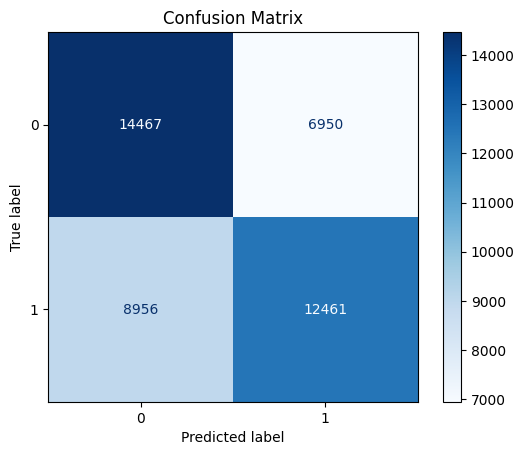

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Generate the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

ROC AUC Score: 0.6784


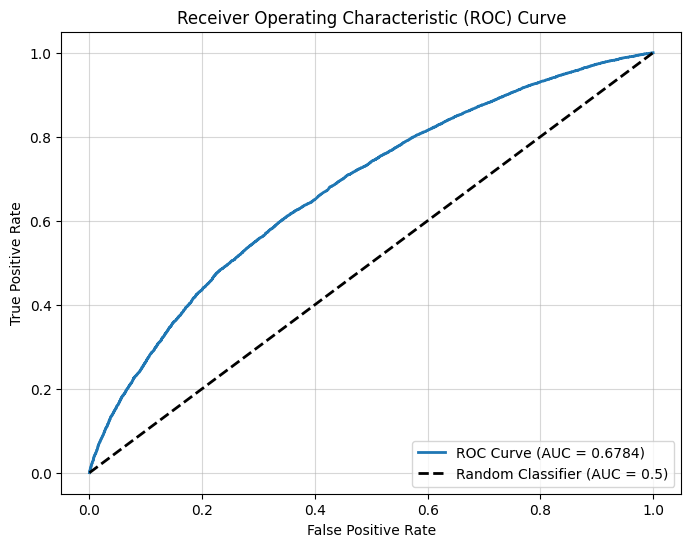

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities for the positive class
y_prob = model.predict_proba(x_test_scale)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)", linewidth=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.show()

#### Inferences:


Logistic regression is a linear model and may not fully capture the complexity of non-linear relationships in the data.

Sentiment analysis often involves contextual and nuanced language, which might not be effectively modeled by a simple linear classifier.

The features (review_len, neg, pos, compound) are limited in scope and may not fully represent the richness of the review text.

#### Recommendations and further improvements:

Move beyond basic features like review_len and VADER scores.

Use advanced NLP techniques to capture richer textual information:
  
   TF-IDF: Vectorize the review text using Term Frequency-Inverse Document Frequency to highlight important words.

   Word Embeddings: Use pre-trained embeddings (e.g., GloVe, Word2Vec) to represent words in a dense, semantic space.

   Contextualized Embeddings: Use models like BERT or RoBERTa to extract sentence-level embeddings, capturing the context of words.

Experiment with Neural Networks,

Feedforward Neural Networks (FNN): Use the extracted features (review_len, sentiment scores) as input to an FNN for classification.

Recurrent Neural Networks (RNN) or LSTMs: Use these to handle sequential data and capture dependencies in the review text.

Transformers: Fine-tune pre-trained models like BERT or DistilBERT for sentiment analysis.

Evaluate the new models using standard metrics like accuracy, precision, recall, and F1-score.

Compare the performance of neural networks and pre-trained models against logistic regression to demonstrate improvements.

Transitioning to neural networks or advanced NLP methods will likely result in significant improvements in performance and the ability to generalize better to unseen data. Starting with simpler neural architectures like FNNs or LSTMs and gradually moving to transformers like BERT would provide a structured way to build.
